In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=948a80ab49d91eaad985b8506648fadf5112c49948e0e0e03692cd51445ffb96
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName('Global Country Data').getOrCreate()

In [ ]:
spark

In [ ]:
df=spark.read.csv("/content/world-data-2023.csv",header=True,inferSchema=True,multiLine=True)

In [ ]:
df.show()

+-------------------+----------------+------------+---------------------+--------------+-----------------+----------+------------+--------------------+-------------+------+--------------+-------------+--------------+-----------------+--------------+-------------------+--------------------------------------+---------------------------------------+----------------+--------------------+---------------+------------------------+------------+--------------------+--------------------------------+-----------------------+-----------+-----------------------------------------+---------------+--------------+-----------------+----------------+----------+------------+
|            Country|Density\n(P/Km2)|Abbreviation|Agricultural Land( %)|Land Area(Km2)|Armed Forces size|Birth Rate|Calling Code|  Capital/Major City|Co2-Emissions|   CPI|CPI Change (%)|Currency-Code|Fertility Rate|Forested Area (%)|Gasoline Price|                GDP|Gross primary education enrollment (%)|Gross tertiary education enro

In [ ]:
df.toPandas().shape

(195, 35)

In [ ]:
# Dropping unwanted columns
df=df.drop('Abbreviation','Currency-Code')

In [ ]:
df = df.withColumnRenamed("Density\n(P/Km2)", "Density (P/Km2)") \
           .withColumnRenamed("Longitude\r", "Longitude")

In [ ]:
from pyspark.sql.functions import col, regexp_replace
df = df.select([regexp_replace(col(c), r'[^\x00-\x7F]+', '').alias(c) for c in df.columns])
df = df.select([regexp_replace(col(c), r'\%', '').alias(c) for c in df.columns])

In [ ]:
df = df.select([regexp_replace(col(c), r'\$', '').alias(c) for c in df.columns])
df = df.select([regexp_replace(col(c), r'\,', '').alias(c) for c in df.columns])
df = df.select([regexp_replace(col(c), r'\r', '').alias(c) for c in df.columns])

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Strip non-numeric characters for columns containing numerical values as strings, then cast to float
columns_to_cast = ['Density (P/Km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size',
                   'Co2-Emissions', 'CPI', 'CPI Change (%)', 'Forested Area (%)',
                   'Gasoline Price', 'Gross primary education enrollment (%)',
                   'Gross tertiary education enrollment (%)', 'Minimum wage',
                   'Out of pocket health expenditure', 'Population', 'Population: Labor force participation (%)',
                   'Tax revenue (%)', 'Total tax rate', 'Unemployment rate', 'Urban_population']


In [ ]:
for col in columns_to_cast:
    df= df.withColumn(col, F.regexp_replace(F.col(col), '[^0-9.]', '').cast(FloatType()))


In [ ]:
# Typecast relevant columns to numeric types (float or integer)
from pyspark.sql.functions import *
df = df.withColumn("Calling Code", col("Calling Code").cast(IntegerType())) \
           .withColumn("Maternal mortality ratio",col("Maternal mortality ratio").cast(IntegerType())) \
           .withColumn("Birth Rate", col("Birth Rate").cast(DoubleType())) \
           .withColumn("Fertility Rate", col("Fertility Rate").cast(DoubleType())) \
           .withColumn("Infant mortality", col("Infant mortality").cast(DoubleType())) \
           .withColumn("Life expectancy", col("Life expectancy").cast(DoubleType())) \
           .withColumn("Physicians per thousand", col("Physicians per thousand").cast(DoubleType())) \
           .withColumn("Latitude", col("Latitude").cast(DoubleType())) \
           .withColumn("Longitude", col("Longitude").cast(DoubleType()))



In [ ]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Density (P/Km2): float (nullable = true)
 |-- Agricultural Land( %): float (nullable = true)
 |-- Land Area(Km2): float (nullable = true)
 |-- Armed Forces size: float (nullable = true)
 |-- Birth Rate: double (nullable = true)
 |-- Calling Code: integer (nullable = true)
 |-- Capital/Major City: string (nullable = true)
 |-- Co2-Emissions: float (nullable = true)
 |-- CPI: float (nullable = true)
 |-- CPI Change (%): float (nullable = true)
 |-- Fertility Rate: double (nullable = true)
 |-- Forested Area (%): float (nullable = true)
 |-- Gasoline Price: float (nullable = true)
 |-- GDP: string (nullable = true)
 |-- Gross primary education enrollment (%): float (nullable = true)
 |-- Gross tertiary education enrollment (%): float (nullable = true)
 |-- Infant mortality: double (nullable = true)
 |-- Largest city: string (nullable = true)
 |-- Life expectancy: double (nullable = true)
 |-- Maternal mortality ratio: integer (nullable = tr

In [ ]:
categorical_cols=['Country','Capital/Major City','Largest city','Official language']

In [ ]:
from pyspark.ml.feature import StringIndexer
indexers=[StringIndexer(inputCol=c,outputCol=f"{c}_indexer",handleInvalid="keep")for c in categorical_cols]

In [ ]:
df=indexers[0].fit(df).transform(df)
df=indexers[1].fit(df).transform(df)
df=indexers[2].fit(df).transform(df)
df=indexers[3].fit(df).transform(df)


In [ ]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Density (P/Km2): float (nullable = true)
 |-- Agricultural Land( %): float (nullable = true)
 |-- Land Area(Km2): float (nullable = true)
 |-- Armed Forces size: float (nullable = true)
 |-- Birth Rate: double (nullable = true)
 |-- Calling Code: integer (nullable = true)
 |-- Capital/Major City: string (nullable = true)
 |-- Co2-Emissions: float (nullable = true)
 |-- CPI: float (nullable = true)
 |-- CPI Change (%): float (nullable = true)
 |-- Fertility Rate: double (nullable = true)
 |-- Forested Area (%): float (nullable = true)
 |-- Gasoline Price: float (nullable = true)
 |-- GDP: string (nullable = true)
 |-- Gross primary education enrollment (%): float (nullable = true)
 |-- Gross tertiary education enrollment (%): float (nullable = true)
 |-- Infant mortality: double (nullable = true)
 |-- Largest city: string (nullable = true)
 |-- Life expectancy: double (nullable = true)
 |-- Maternal mortality ratio: integer (nullable = tr

In [ ]:
# Checking the shape of the dataset
df.toPandas().shape

(195, 37)

In [ ]:
df.toPandas().isnull().sum()

,0
Country,0
Density (P/Km2),0
Agricultural Land( %),7
Land Area(Km2),1
Armed Forces size,24
Birth Rate,6
Calling Code,1
Capital/Major City,3
Co2-Emissions,7
CPI,17


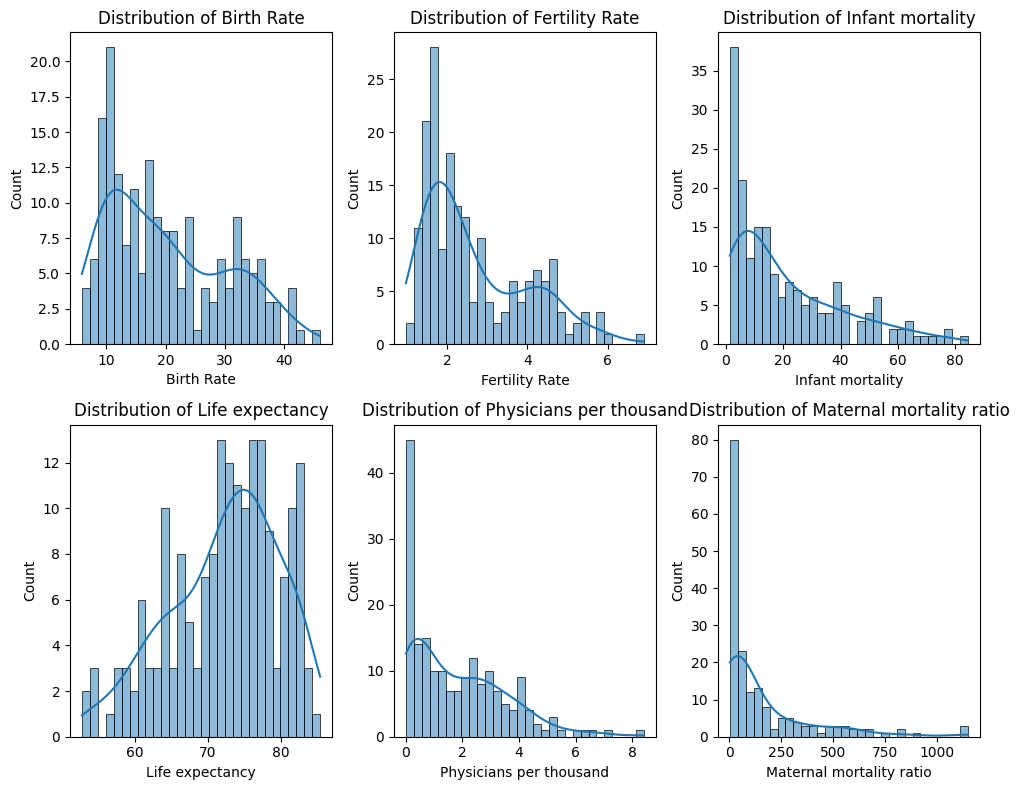

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert a PySpark DataFrame to Pandas for plotting
numeric_cols = ['Birth Rate', 'Fertility Rate', 'Infant mortality', 'Life expectancy',
                'Physicians per thousand', 'Maternal mortality ratio']

df_pd = df.select(numeric_cols).toPandas()

# Plot histograms to visually inspect the distribution
plt.figure(figsize=(10, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_pd[col].dropna(), kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


In [ ]:
# Handling null values
from pyspark.ml.feature import Imputer
# Impute missing numerical values with median

numerical_columns = ['Population','CPI','Armed Forces size','Gross tertiary education enrollment (%)','CPI Change (%)',
                     'Co2-Emissions', 'Tax revenue (%)', 'Life expectancy',
                     'Unemployment rate','Urban_population','Population: Labor force participation (%)',
                     'Minimum wage','Maternal mortality ratio','Gasoline Price','Forested Area (%)','Fertility Rate',
                     'Agricultural Land( %)','Total tax rate','Land Area(Km2)',
                     'Physicians per thousand','Out of pocket health expenditure',
                     'Infant mortality','Gross primary education enrollment (%)','Birth Rate']

imputer=Imputer(inputCols=numerical_columns,outputCols=numerical_columns)
imputer.setStrategy("median")
df=imputer.fit(df).transform(df)

In [ ]:
df.show()

+-------------------+---------------+---------------------+--------------+-----------------+----------+------------+--------------------+-------------+------+--------------+--------------+-----------------+--------------+--------------+--------------------------------------+---------------------------------------+----------------+--------------------+---------------+------------------------+------------+--------------------+--------------------------------+-----------------------+------------+-----------------------------------------+---------------+--------------+-----------------+----------------+----------+----------+---------------+--------------------------+--------------------+-------------------------+
|            Country|Density (P/Km2)|Agricultural Land( %)|Land Area(Km2)|Armed Forces size|Birth Rate|Calling Code|  Capital/Major City|Co2-Emissions|   CPI|CPI Change (%)|Fertility Rate|Forested Area (%)|Gasoline Price|           GDP|Gross primary education enrollment (%)|Gross 

In [ ]:
# Removing  duplicate rows

df = df.dropDuplicates()

In [ ]:
df.toPandas().shape

(195, 37)

In [ ]:
df.toPandas().isnull().sum()

,0
Country,0
Density (P/Km2),0
Agricultural Land( %),0
Land Area(Km2),0
Armed Forces size,0
Birth Rate,0
Calling Code,1
Capital/Major City,3
Co2-Emissions,0
CPI,0


In [ ]:
#dropping the rows with null value

df=df.dropna(how="any")

In [ ]:
df.toPandas().isnull().sum()

,0
Country,0
Density (P/Km2),0
Agricultural Land( %),0
Land Area(Km2),0
Armed Forces size,0
Birth Rate,0
Calling Code,0
Capital/Major City,0
Co2-Emissions,0
CPI,0


In [ ]:
df.toPandas().shape

(188, 37)

In [ ]:
df.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Density (P/Km2),188.0,3.058777e+02,1.927942e+03,2.000000,3.475000e+01,8.550000e+01,2.052500e+02,2.633700e+04
Agricultural Land( %),188.0,3.962287e+01,2.129976e+01,0.600000,2.310000e+01,3.950000e+01,5.537500e+01,8.260000e+01
Land Area(Km2),188.0,7.022346e+05,1.947336e+06,2.000000,2.781000e+04,1.311635e+05,5.410678e+05,1.709824e+07
Armed Forces size,188.0,1.478564e+05,3.646910e+05,0.000000,1.300000e+04,3.100000e+04,1.267500e+05,3.031000e+06
Birth Rate,188.0,2.021495e+01,9.898773e+00,5.900000,1.137500e+01,1.795000e+01,2.866750e+01,4.608000e+01
Calling Code,188.0,3.600957e+02,3.257758e+02,1.000000,8.175000e+01,2.555000e+02,5.062500e+02,1.876000e+03
Co2-Emissions,188.0,1.775440e+05,8.388336e+05,11.000000,2.480000e+03,1.197300e+04,6.388425e+04,9.893038e+06
CPI,188.0,1.868560e+02,3.874304e+02,99.550003,1.144950e+02,1.250800e+02,1.557250e+02,4.583710e+03
CPI Change (%),188.0,6.743085e+00,2.380455e+01,0.100000,1.200000e+00,2.500000e+00,3.950000e+00,2.549000e+02
Fertility Rate,188.0,2.695000e+00,1.271484e+00,0.980000,1.710000e+00,2.240000e+00,3.575000e+00,6.910000e+00


In [ ]:
df.show()

+--------------------+---------------+---------------------+--------------+-----------------+----------+------------+-------------------+-------------+------+--------------+--------------+-----------------+--------------+--------------+--------------------------------------+---------------------------------------+----------------+-------------------+---------------+------------------------+------------+-----------------+--------------------------------+-----------------------+------------+-----------------------------------------+---------------+--------------+-----------------+----------------+----------+-----------+---------------+--------------------------+--------------------+-------------------------+
|             Country|Density (P/Km2)|Agricultural Land( %)|Land Area(Km2)|Armed Forces size|Birth Rate|Calling Code| Capital/Major City|Co2-Emissions|   CPI|CPI Change (%)|Fertility Rate|Forested Area (%)|Gasoline Price|           GDP|Gross primary education enrollment (%)|Gross ter

Correlation matrix

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F

# Select numerical columns for correlation
numeric_cols = ['Population', 'Co2-Emissions', 'Tax revenue (%)', 'Life expectancy',
                  'Land Area(Km2)', 'Birth Rate', 'Fertility Rate', 'Infant mortality',
                  'Maternal mortality ratio', 'Physicians per thousand']

# Assemble columns into a vector for correlation computation
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
vectorized_data = assembler.transform(df).select("features")

# Compute correlation matrix
correlation_matrix = Correlation.corr(vectorized_data, "features").head()

# Convert correlation matrix to a dense array
correlation_array = correlation_matrix[0].toArray()

# Convert to Pandas DataFrame for plotting
import pandas as pd

correlation_df = pd.DataFrame(correlation_array, index=numeric_cols, columns=numeric_cols)



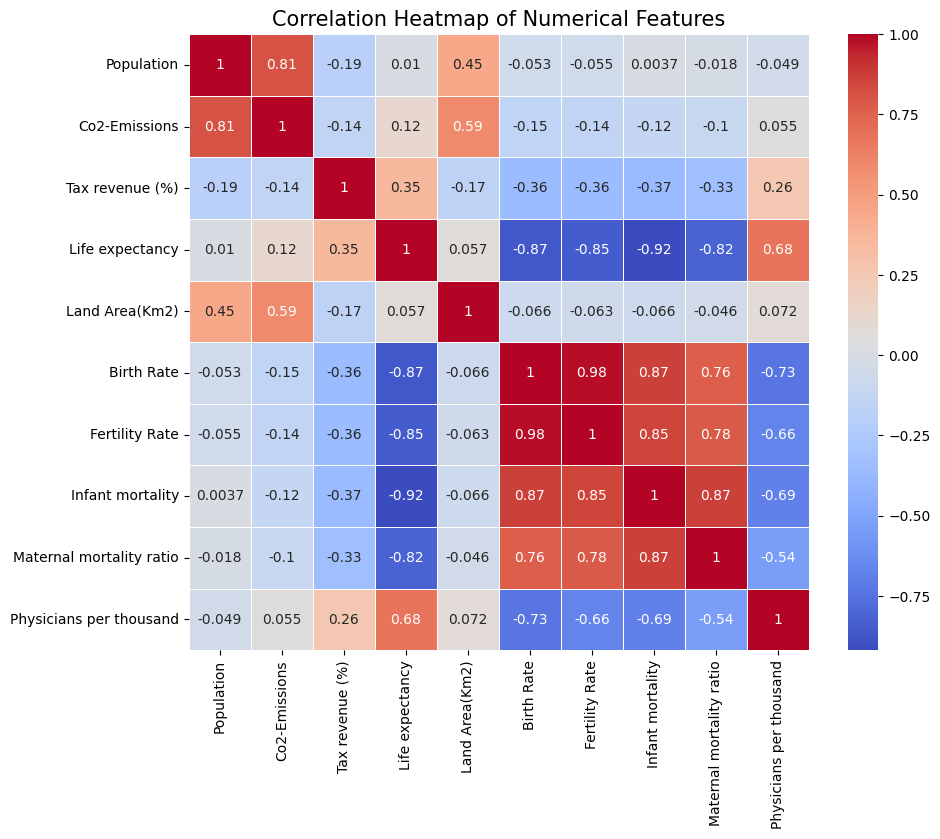

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap with annotations for better clarity
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", linewidths=0.5)

# Set titles and labels
plt.title('Correlation Heatmap of Numerical Features', fontsize=15)
plt.show()


In [ ]:
data=df.toPandas().to_csv("Global_country_data_cleaned.csv")

In [ ]:
data